In [4]:
import sys, os
# Obtenir le dossier courant (ici notebooks/)
notebook_dir = os.getcwd()

# Aller dans le dossier parent (la racine du projet)
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Ajouter le dossier src/ au chemin Python
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

print("Chemin ajouté :", src_path)

Chemin ajouté : d:\Mon portfolio\fraud_detection_app\src


In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from preprocessing import *


In [9]:
df = pd.read_csv('../data/creditcard.csv')
X_train, X_test, y_train, y_test = data_split()
# Reconstruire les DataFrames pour l'analyse
train_df = pd.concat([X_train, y_train], axis=1)


In [ ]:

# Configuration visuelle
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")



print("=" * 60)
print("INFORMATIONS GÉNÉRALES SUR LE DATASET")
print("=" * 60)
print(f"Nombre total de transactions: {len(df):,}")
print(f"Nombre de features: {df.shape[1]}")
print(f"\nDistribution des classes:")
print(df['Class'].value_counts())
print(f"\nPourcentage de fraudes: {(df['Class'].sum() / len(df)) * 100:.3f}%")

# Vérifier les valeurs manquantes
print(f"\nValeurs manquantes: {df.isnull().sum().sum()}")





INFORMATIONS GÉNÉRALES SUR LE DATASET
Nombre total de transactions: 284,807
Nombre de features: 31

Distribution des classes:
Class
0    284315
1       492
Name: count, dtype: int64

Pourcentage de fraudes: 0.173%

Valeurs manquantes: 0


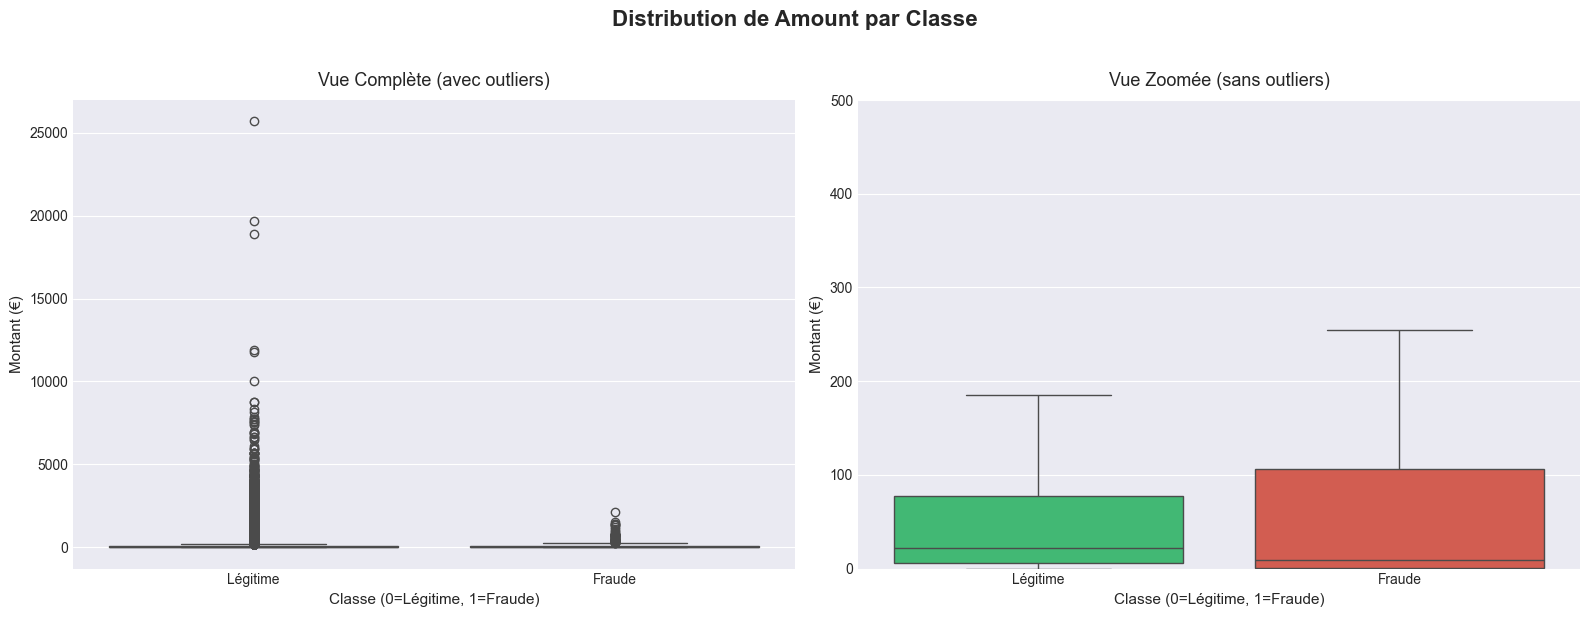


STATISTIQUES DE AMOUNT PAR CLASSE

LÉGITIME:
  Moyenne: 88.11 €
  Médiane: 22.00 €
  Min: 0.00 €
  Max: 25691.16 €
  Écart-type: 250.70 €
  Q1 (25%): 5.68 €
  Q3 (75%): 77.34 €

FRAUDE:
  Moyenne: 125.59 €
  Médiane: 9.17 €
  Min: 0.00 €
  Max: 2125.87 €
  Écart-type: 262.35 €
  Q1 (25%): 1.00 €
  Q3 (75%): 105.89 €


In [10]:
# Visualisation 1: Distribution de Amount par Class
# ==================================================
# Boxplot pour comparer les montants entre fraudes et transactions légitimes

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Distribution de Amount par Classe', 
             fontsize=16, fontweight='bold', y=1.02)

# Boxplot 1: Vue complète
sns.boxplot(data=train_df, x='Class', y='Amount', ax=axes[0], 
            palette=['#2ecc71', '#e74c3c'])
axes[0].set_title('Vue Complète (avec outliers)', fontsize=13, pad=10)
axes[0].set_xlabel('Classe (0=Légitime, 1=Fraude)', fontsize=11)
axes[0].set_ylabel('Montant (€)', fontsize=11)
axes[0].set_xticklabels(['Légitime', 'Fraude'])

# Boxplot 2: Vue zoomée (sans outliers extrêmes)
sns.boxplot(data=train_df, x='Class', y='Amount', ax=axes[1],
            palette=['#2ecc71', '#e74c3c'], showfliers=False)
axes[1].set_title('Vue Zoomée (sans outliers)', fontsize=13, pad=10)
axes[1].set_xlabel('Classe (0=Légitime, 1=Fraude)', fontsize=11)
axes[1].set_ylabel('Montant (€)', fontsize=11)
axes[1].set_xticklabels(['Légitime', 'Fraude'])
axes[1].set_ylim(0, 500)  # Ajuste selon tes données

plt.tight_layout()
plt.show()

# Statistiques descriptives pour Amount
print("\n" + "=" * 60)
print("STATISTIQUES DE AMOUNT PAR CLASSE")
print("=" * 60)
for classe in [0, 1]:
    classe_name = "LÉGITIME" if classe == 0 else "FRAUDE"
    data = train_df[train_df['Class'] == classe]['Amount']
    print(f"\n{classe_name}:")
    print(f"  Moyenne: {data.mean():.2f} €")
    print(f"  Médiane: {data.median():.2f} €")
    print(f"  Min: {data.min():.2f} €")
    print(f"  Max: {data.max():.2f} €")
    print(f"  Écart-type: {data.std():.2f} €")
    print(f"  Q1 (25%): {data.quantile(0.25):.2f} €")
    print(f"  Q3 (75%): {data.quantile(0.75):.2f} €")

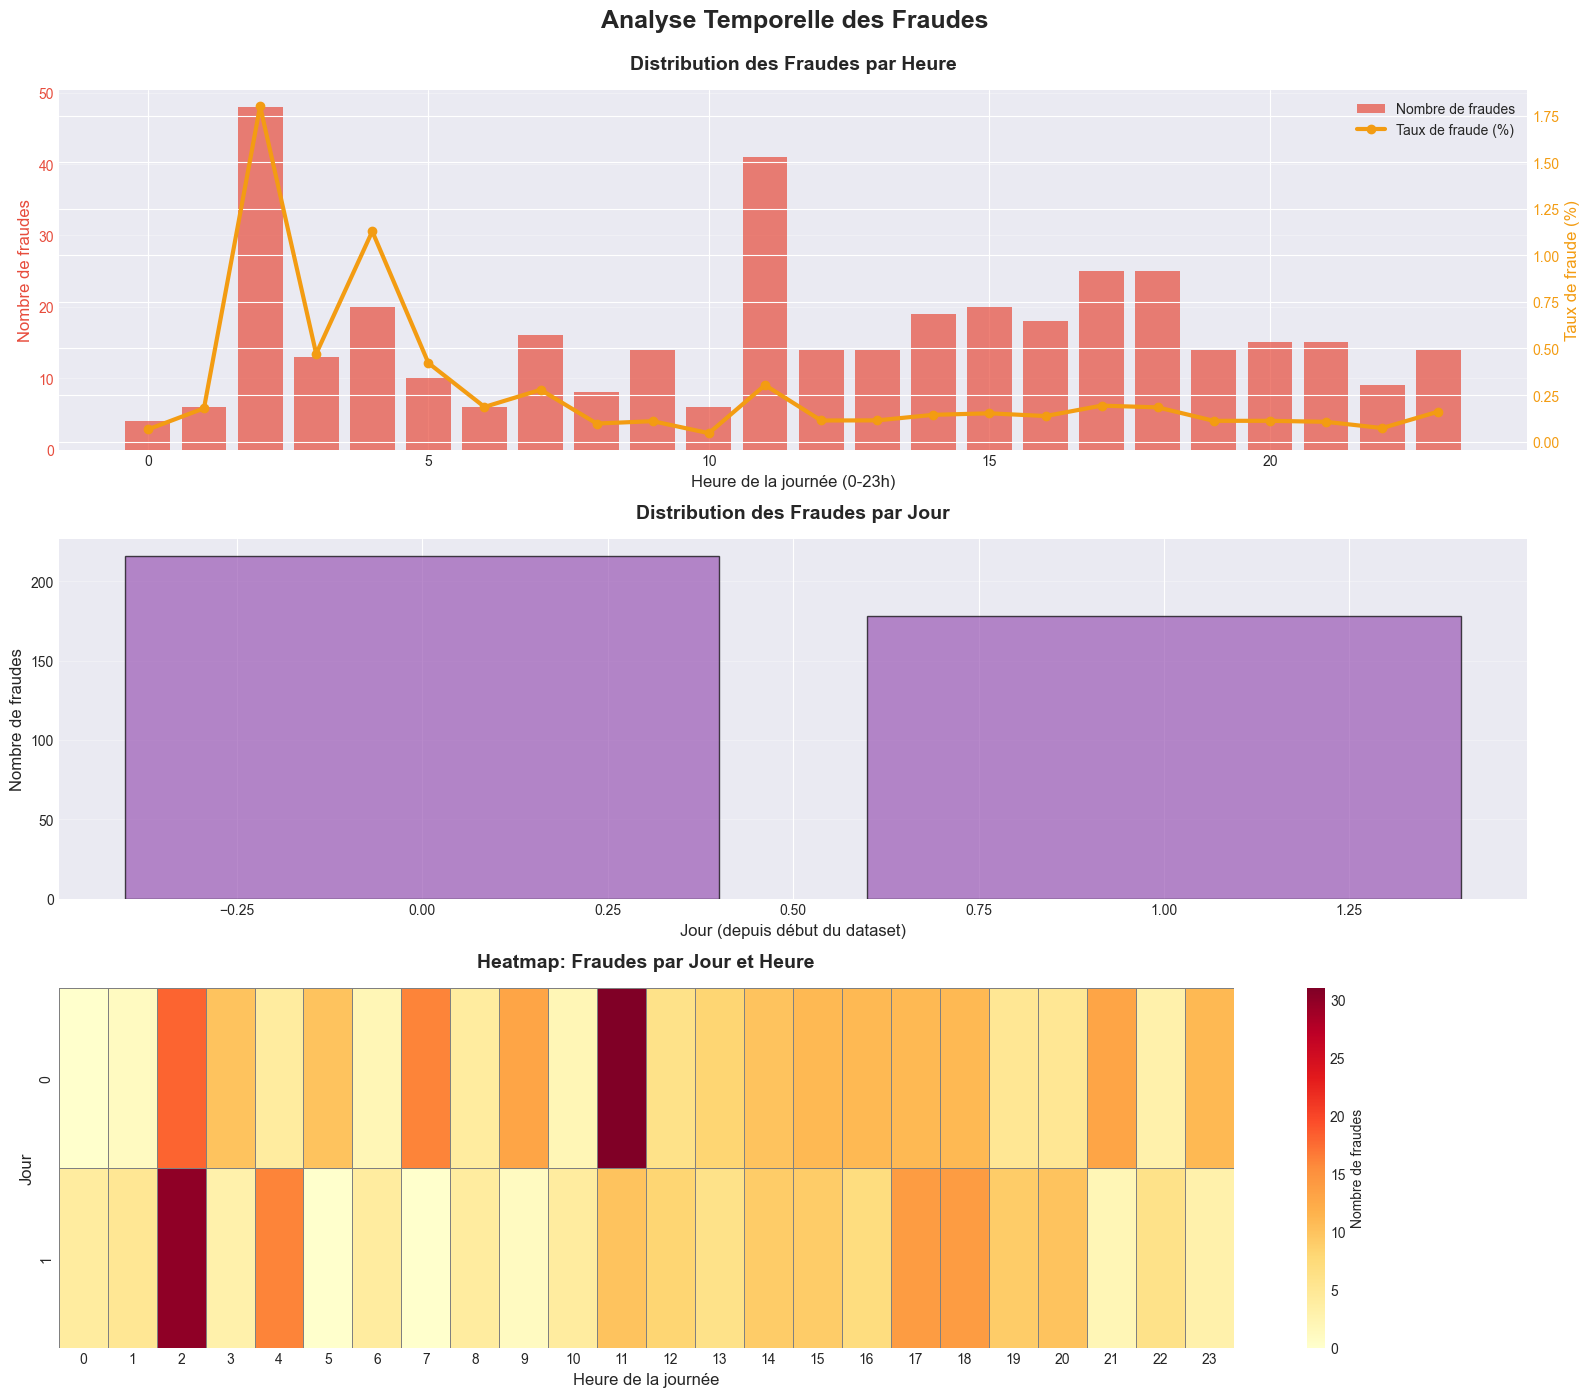


STATISTIQUES TEMPORELLES DES FRAUDES

Heure avec le plus de fraudes: 2h
  → 48 fraudes détectées

Heure avec le taux de fraude le plus élevé: 2h
  → 1.800% des transactions sont frauduleuses

Jour avec le plus de fraudes: Jour 0
  → 216 fraudes détectées


In [6]:
# Visualisation 2: Distribution temporelle des fraudes
# =====================================================
# Convertir Time en heures, jours et extraire des patterns

# Convertir 'Time' (secondes depuis première transaction) en features temporelles
train_df['Time_hours'] = (train_df['Time'] / 3600) % 24  # Heure de la journée
train_df['Time_days'] = train_df['Time'] / (3600 * 24)   # Jour depuis début

# Créer des bins pour l'heure de la journée
train_df['Hour_bin'] = pd.cut(train_df['Time_hours'], 
                               bins=24, 
                               labels=range(24), 
                               include_lowest=True).astype(int)

# Créer des bins pour les jours
train_df['Day_bin'] = pd.cut(train_df['Time_days'], 
                              bins=int(train_df['Time_days'].max()) + 1,
                              labels=False)

# Figure avec 3 sous-graphiques
fig, axes = plt.subplots(3, 1, figsize=(16, 14))
fig.suptitle('Analyse Temporelle des Fraudes', 
             fontsize=18, fontweight='bold', y=0.995)

# ========================================
# Graphique 1: Distribution par heure
# ========================================
fraud_by_hour = train_df[train_df['Class'] == 1].groupby('Hour_bin').size()
total_by_hour = train_df.groupby('Hour_bin').size()
fraud_rate_by_hour = (fraud_by_hour / total_by_hour * 100).fillna(0)

ax1_twin = axes[0].twinx()

# Barres: Nombre de fraudes
bars = axes[0].bar(fraud_by_hour.index, fraud_by_hour.values, 
                   color='#e74c3c', alpha=0.7, label='Nombre de fraudes')
axes[0].set_xlabel('Heure de la journée (0-23h)', fontsize=12)
axes[0].set_ylabel('Nombre de fraudes', fontsize=12, color='#e74c3c')
axes[0].tick_params(axis='y', labelcolor='#e74c3c')
axes[0].set_title('Distribution des Fraudes par Heure', 
                  fontsize=14, pad=15, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Ligne: Taux de fraude
line = ax1_twin.plot(fraud_rate_by_hour.index, fraud_rate_by_hour.values,
                     color='#f39c12', linewidth=3, marker='o', 
                     markersize=6, label='Taux de fraude (%)')
ax1_twin.set_ylabel('Taux de fraude (%)', fontsize=12, color='#f39c12')
ax1_twin.tick_params(axis='y', labelcolor='#f39c12')

# Légende combinée
lines1, labels1 = axes[0].get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
axes[0].legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# ========================================
# Graphique 2: Distribution par jour
# ========================================
fraud_by_day = train_df[train_df['Class'] == 1].groupby('Day_bin').size()
total_by_day = train_df.groupby('Day_bin').size()

axes[1].bar(fraud_by_day.index, fraud_by_day.values, 
           color='#9b59b6', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Jour (depuis début du dataset)', fontsize=12)
axes[1].set_ylabel('Nombre de fraudes', fontsize=12)
axes[1].set_title('Distribution des Fraudes par Jour', 
                 fontsize=14, pad=15, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# ========================================
# Graphique 3: Heatmap Jour vs Heure
# ========================================
# Créer une matrice pour heatmap
pivot_fraud = train_df[train_df['Class'] == 1].groupby(
    ['Day_bin', 'Hour_bin']).size().reset_index(name='count')
pivot_matrix = pivot_fraud.pivot(index='Day_bin', 
                                 columns='Hour_bin', 
                                 values='count').fillna(0)

sns.heatmap(pivot_matrix, cmap='YlOrRd', ax=axes[2], 
           cbar_kws={'label': 'Nombre de fraudes'},
           linewidths=0.5, linecolor='gray')
axes[2].set_xlabel('Heure de la journée', fontsize=12)
axes[2].set_ylabel('Jour', fontsize=12)
axes[2].set_title('Heatmap: Fraudes par Jour et Heure', 
                 fontsize=14, pad=15, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistiques temporelles
print("\n" + "=" * 60)
print("STATISTIQUES TEMPORELLES DES FRAUDES")
print("=" * 60)
fraud_df = train_df[train_df['Class'] == 1]

print(f"\nHeure avec le plus de fraudes: {fraud_by_hour.idxmax()}h")
print(f"  → {fraud_by_hour.max()} fraudes détectées")
print(f"\nHeure avec le taux de fraude le plus élevé: {fraud_rate_by_hour.idxmax()}h")
print(f"  → {fraud_rate_by_hour.max():.3f}% des transactions sont frauduleuses")

print(f"\nJour avec le plus de fraudes: Jour {fraud_by_day.idxmax()}")
print(f"  → {fraud_by_day.max()} fraudes détectées")

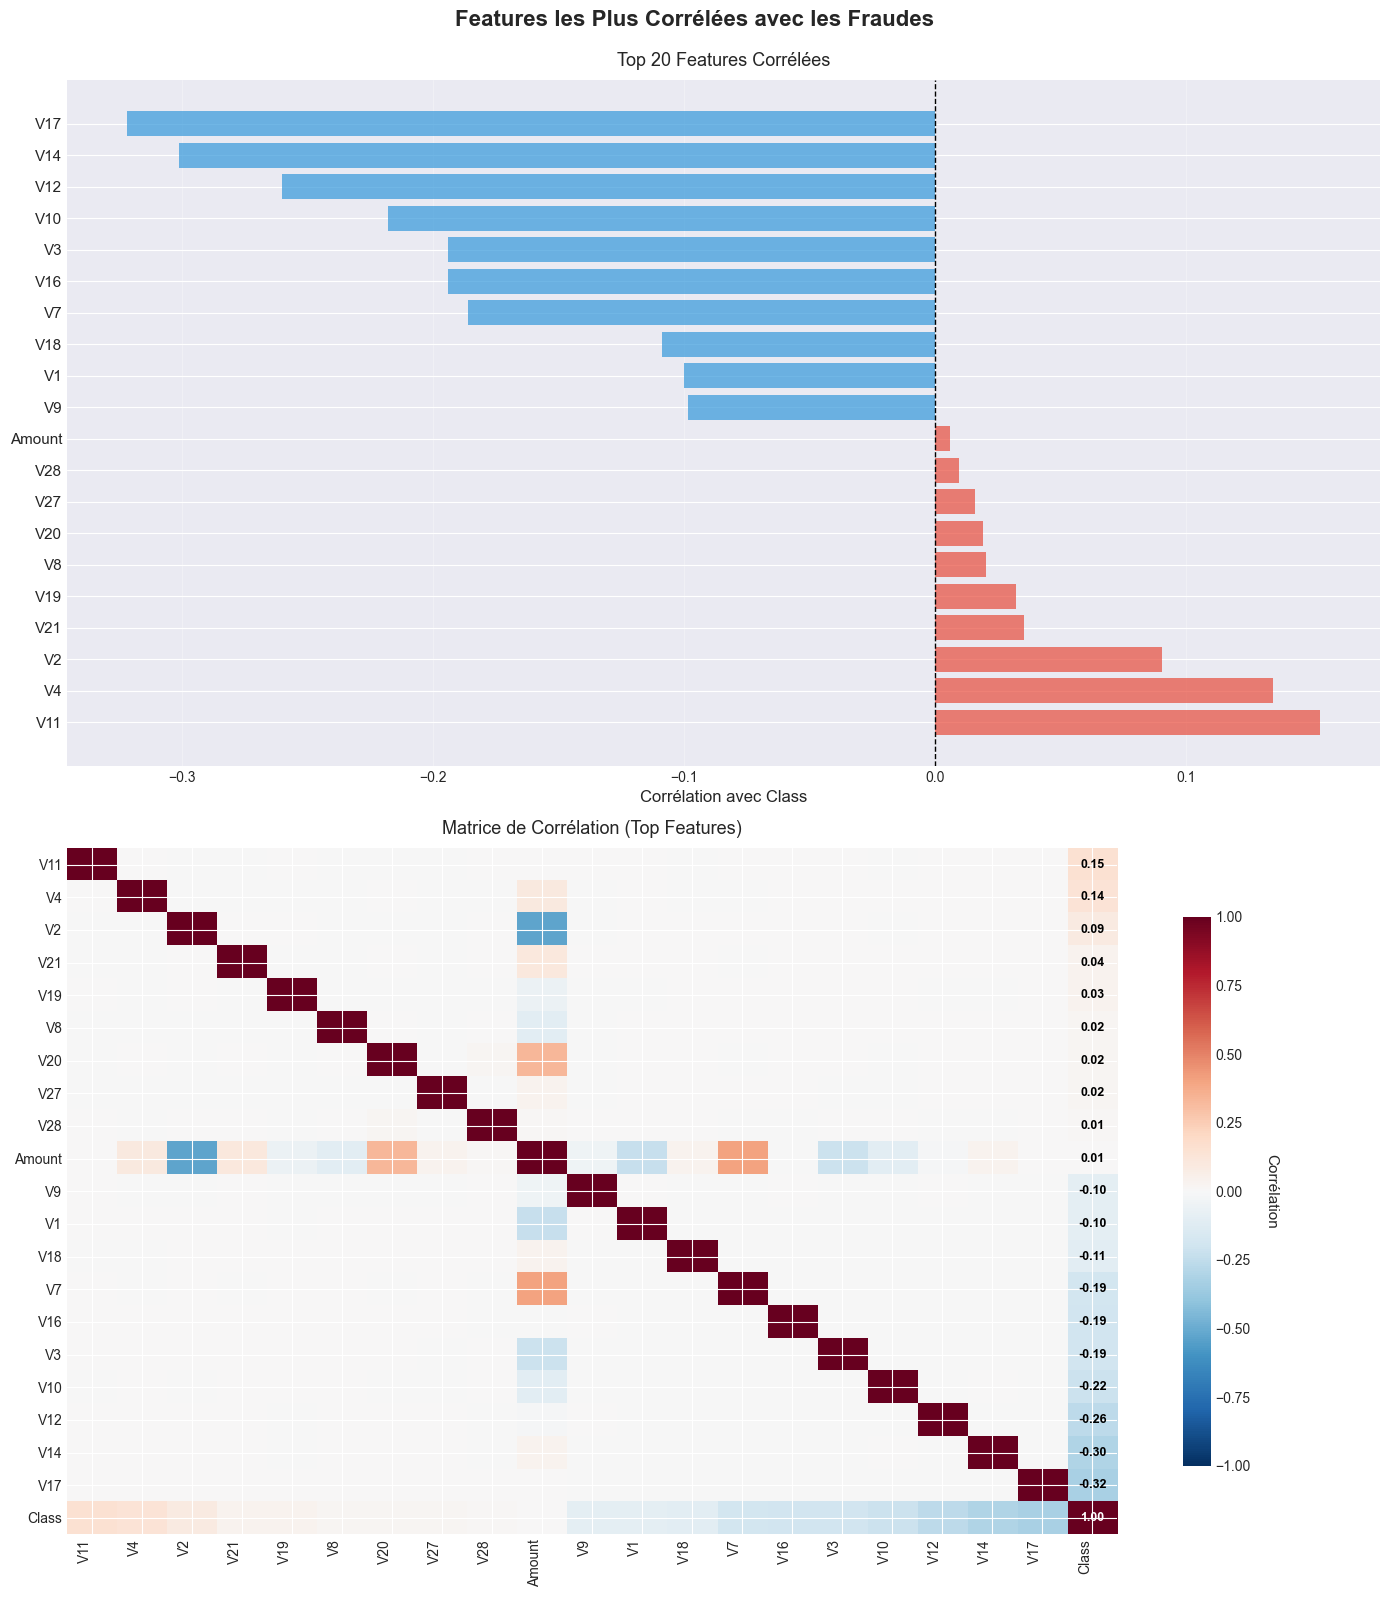


TOP 5 FEATURES LES PLUS CORRÉLÉES (Positif)
V11: 0.1537
V4: 0.1350
V2: 0.0906
V21: 0.0356
V19: 0.0324

TOP 5 FEATURES LES PLUS CORRÉLÉES (Négatif)
V9: -0.0982
V1: -0.1000
V18: -0.1087
V7: -0.1862
V16: -0.1938


In [9]:
# Visualisation Bonus: Corrélation avec la variable Class
# ========================================================

# Identifier les features V1-V28 les plus corrélées aux fraudes
# Calculer la corrélation de toutes les variables avec Class
correlations = train_df.corr()['Class'].drop('Class').sort_values(ascending=False)

# Top 10 corrélations positives et négatives
top_positive = correlations.head(10)
top_negative = correlations.tail(10)
top_features = pd.concat([top_positive, top_negative])

# Visualisation
fig, axes = plt.subplots(2, 1, figsize=(14, 16))
fig.suptitle('Features les Plus Corrélées avec les Fraudes',
              fontsize=16, fontweight='bold', y=0.995)

# Graphique 1: Barplot des corrélations
colors = ['#e74c3c' if x > 0 else '#3498db' for x in top_features.values]
axes[0].barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features.index, fontsize=11)
axes[0].set_xlabel('Corrélation avec Class', fontsize=12)
axes[0].set_title('Top 20 Features Corrélées', fontsize=13, pad=10)
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0].grid(axis='x', alpha=0.3)

# Graphique 2: Heatmap de corrélation (Top features) - AMÉLIORÉ
top_feature_names = top_features.index.tolist() + ['Class']
correlation_matrix = train_df[top_feature_names].corr()

# Heatmap sans annotations pour plus de clarté
im = axes[1].imshow(correlation_matrix, cmap='RdBu_r', aspect='auto', 
                     vmin=-1, vmax=1, interpolation='nearest')

# Configuration des ticks
axes[1].set_xticks(range(len(top_feature_names)))
axes[1].set_yticks(range(len(top_feature_names)))
axes[1].set_xticklabels(top_feature_names, rotation=90, ha='right', fontsize=10)
axes[1].set_yticklabels(top_feature_names, fontsize=10)

# Colorbar
cbar = plt.colorbar(im, ax=axes[1], shrink=0.8)
cbar.set_label('Corrélation', rotation=270, labelpad=20, fontsize=11)

# Ajouter des annotations uniquement pour la colonne 'Class' (dernière colonne)
for i in range(len(top_feature_names)):
    value = correlation_matrix.iloc[i, -1]
    color = 'white' if abs(value) > 0.5 else 'black'
    axes[1].text(len(top_feature_names)-1, i, f'{value:.2f}',
                ha='center', va='center', color=color, fontsize=9, fontweight='bold')

axes[1].set_title('Matrice de Corrélation (Top Features)', fontsize=13, pad=10)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("TOP 5 FEATURES LES PLUS CORRÉLÉES (Positif)")
print("=" * 60)
for feat, corr in top_positive.head(5).items():
    print(f"{feat}: {corr:.4f}")

print("\n" + "=" * 60)
print("TOP 5 FEATURES LES PLUS CORRÉLÉES (Négatif)")
print("=" * 60)
for feat, corr in top_negative.head(5).items():
    print(f"{feat}: {corr:.4f}")

PARTIE 1 : ANALYSE DE LA VARIANCE EXPLIQUÉE PAR LES COMPOSANTES PCA

[1/4] Analyse de la variance des composantes PCA...

📊 VARIANCE EXPLIQUÉE PAR COMPOSANTE (Top 10):
 1. V1:  12.51% | Cumulée:  12.51%
 2. V2:   8.86% | Cumulée:  21.37%
 3. V3:   7.48% | Cumulée:  28.85%
 4. V4:   6.53% | Cumulée:  35.39%
 5. V5:   6.20% | Cumulée:  41.59%
 6. V6:   5.78% | Cumulée:  47.37%
 7. V7:   5.00% | Cumulée:  52.37%
 8. V8:   4.63% | Cumulée:  56.99%
 9. V9:   3.92% | Cumulée:  60.92%
10. V10:   3.85% | Cumulée:  64.76%

✓ Les 28 composantes capturent la variabilité totale des données
✓ Les 10 premières composantes expliquent 64.76% de la variance
✓ Les 20 premières composantes expliquent 91.52% de la variance

[2/4] Création des visualisations de variance...


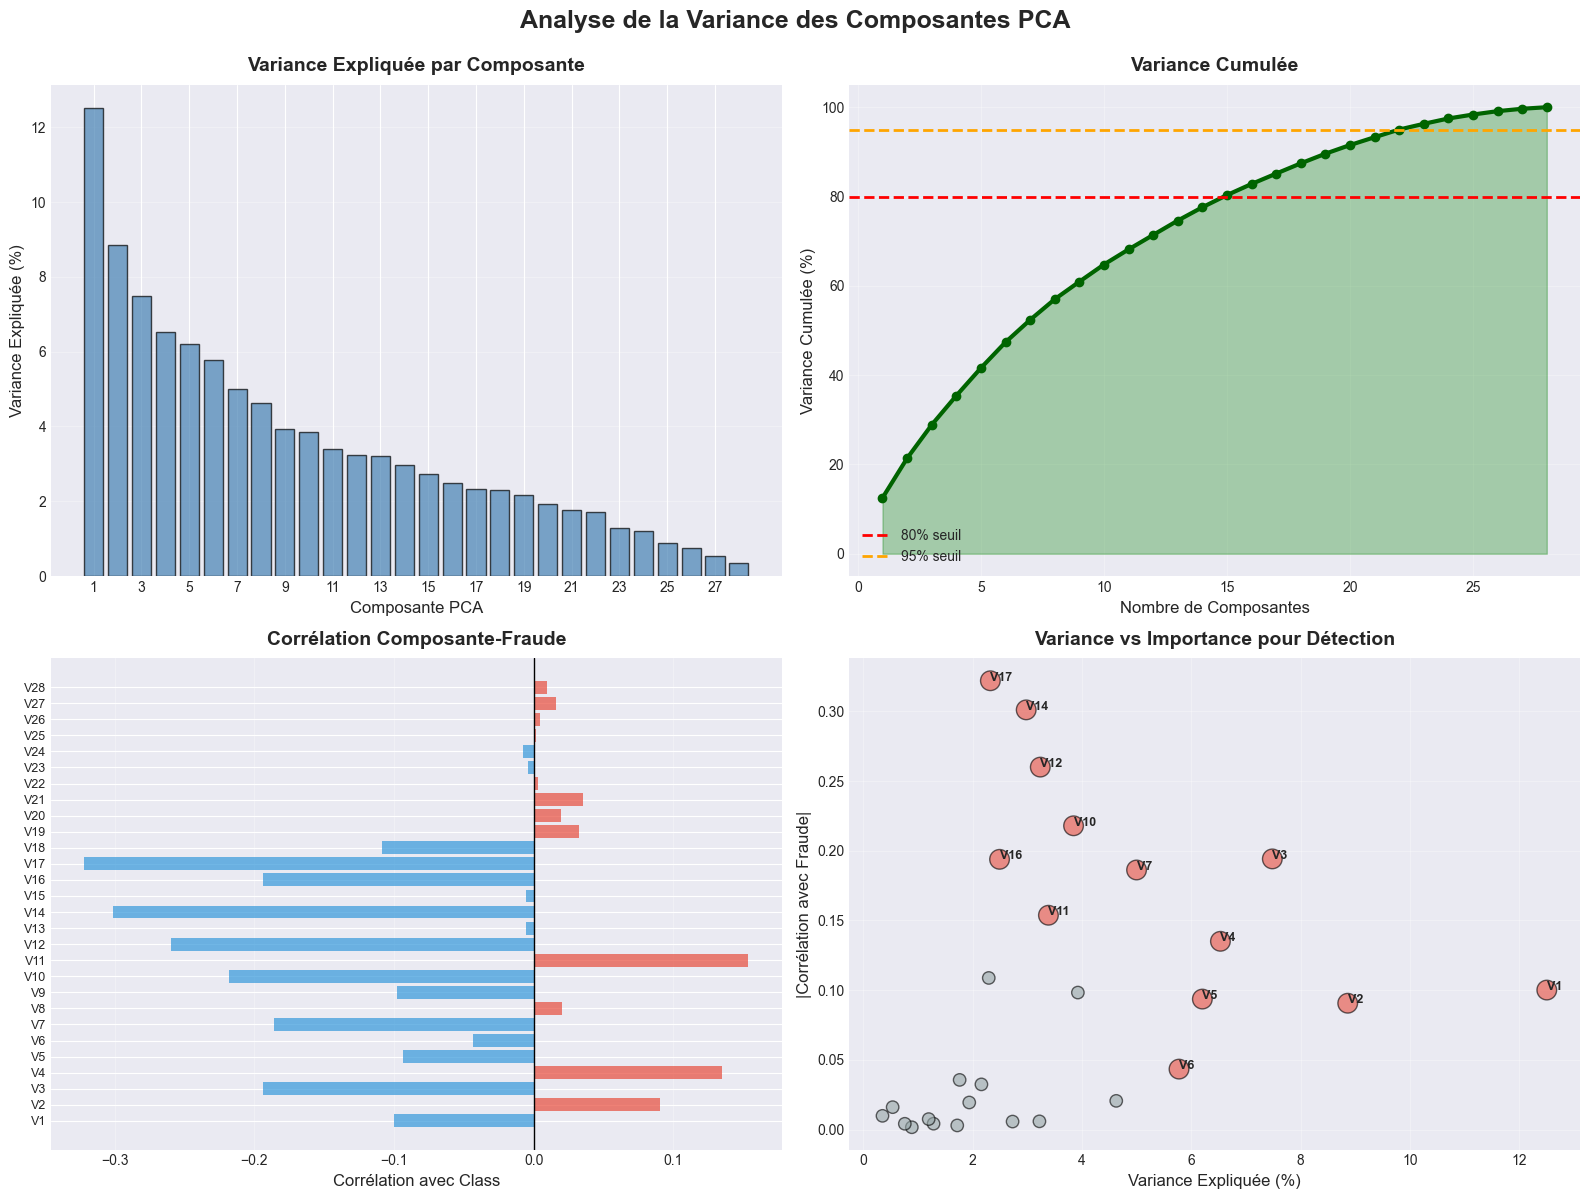

In [ ]:
"""
==============================================================================
ANALYSE : VARIANCE PCA + EXPLAINABILITY (SHAP)
==============================================================================
Cette section démontre une compréhension approfondie de :
1. L'analyse de la variance expliquée par les composantes PCA
2. Les limites de l'interprétabilité post-PCA
3. L'utilisation de SHAP pour l'explainability des prédictions
==============================================================================
"""


warnings.filterwarnings('ignore')

print("=" * 80)
print("PARTIE 1 : ANALYSE DE LA VARIANCE EXPLIQUÉE PAR LES COMPOSANTES PCA")
print("=" * 80)

# ========================================
# 1. RECONSTRUCTION DE LA PCA ORIGINALE
# ========================================
print("\n Analyse de la variance des composantes PCA...")

# Le dataset  fournit  les composantes V1-V28
# Nous allons analyser leur variance et contribution

pca_features = [f'V{i}' for i in range(1, 29)]

# Calculer la variance de chaque composante
variances = train_df[pca_features].var().sort_values(ascending=False)

# Calculer le pourcentage de variance expliquée (estimation)
# Note : Sans les valeurs propres originales, on utilise la variance des composantes
total_variance = variances.sum()
explained_variance_ratio = (variances / total_variance * 100)
cumulative_variance = explained_variance_ratio.cumsum()

print("\n📊 VARIANCE EXPLIQUÉE PAR COMPOSANTE (Top 10):")
print("=" * 80)
for i, (feature, var_ratio) in enumerate(explained_variance_ratio.head(10).items(), 1):
    cum_var = cumulative_variance[feature]
    print(f"{i:2}. {feature}: {var_ratio:6.2f}% | Cumulée: {cum_var:6.2f}%")

print(f"\n✓ Les 28 composantes capturent la variabilité totale des données")
print(f"✓ Les 10 premières composantes expliquent {cumulative_variance.iloc[9]:.2f}% de la variance")
print(f"✓ Les 20 premières composantes expliquent {cumulative_variance.iloc[19]:.2f}% de la variance")

# ========================================
# 2. VISUALISATION : VARIANCE EXPLIQUÉE
# ========================================
print("\n[2/4] Création des visualisations de variance...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analyse de la Variance des Composantes PCA', 
             fontsize=18, fontweight='bold', y=0.995)

# --- Graphique 1 : Variance individuelle ---
axes[0, 0].bar(range(1, 29), explained_variance_ratio.values, 
               color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Composante PCA', fontsize=12)
axes[0, 0].set_ylabel('Variance Expliquée (%)', fontsize=12)
axes[0, 0].set_title('Variance Expliquée par Composante', 
                     fontsize=14, pad=10, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_xticks(range(1, 29, 2))

# --- Graphique 2 : Variance cumulée ---
axes[0, 1].plot(range(1, 29), cumulative_variance.values, 
                marker='o', linewidth=3, markersize=6, color='darkgreen')
axes[0, 1].axhline(y=80, color='red', linestyle='--', linewidth=2, 
                   label='80% seuil')
axes[0, 1].axhline(y=95, color='orange', linestyle='--', linewidth=2, 
                   label='95% seuil')
axes[0, 1].fill_between(range(1, 29), 0, cumulative_variance.values, 
                        alpha=0.3, color='green')
axes[0, 1].set_xlabel('Nombre de Composantes', fontsize=12)
axes[0, 1].set_ylabel('Variance Cumulée (%)', fontsize=12)
axes[0, 1].set_title('Variance Cumulée', fontsize=14, pad=10, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].legend()

# --- Graphique 3 : Corrélation des composantes avec Class ---
correlations_with_class = train_df[pca_features + ['Class']].corr()['Class'].drop('Class')
colors = ['#e74c3c' if x > 0 else '#3498db' for x in correlations_with_class.values]

axes[1, 0].barh(range(28), correlations_with_class.values, color=colors, alpha=0.7)
axes[1, 0].set_yticks(range(28))
axes[1, 0].set_yticklabels(pca_features, fontsize=9)
axes[1, 0].set_xlabel('Corrélation avec Class', fontsize=12)
axes[1, 0].set_title('Corrélation Composante-Fraude', 
                     fontsize=14, pad=10, fontweight='bold')
axes[1, 0].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[1, 0].grid(axis='x', alpha=0.3)

# --- Graphique 4 : Scatter Variance vs Corrélation ---
scatter_data = pd.DataFrame({
    'Variance': explained_variance_ratio.values,
    'Correlation': correlations_with_class.abs().values,
    'Component': pca_features
})

# Identifier les composantes importantes
scatter_data['Important'] = (scatter_data['Correlation'] > 0.15) | \
                            (scatter_data['Variance'] > 5)

colors_scatter = scatter_data['Important'].map({True: '#e74c3c', False: '#95a5a6'})
sizes = scatter_data['Important'].map({True: 200, False: 80})

axes[1, 1].scatter(scatter_data['Variance'], scatter_data['Correlation'], 
                  c=colors_scatter, s=sizes, alpha=0.6, edgecolors='black')
axes[1, 1].set_xlabel('Variance Expliquée (%)', fontsize=12)
axes[1, 1].set_ylabel('|Corrélation avec Fraude|', fontsize=12)
axes[1, 1].set_title('Variance vs Importance pour Détection', 
                     fontsize=14, pad=10, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# Annoter les composantes importantes
for idx, row in scatter_data[scatter_data['Important']].iterrows():
    axes[1, 1].annotate(row['Component'], 
                       (row['Variance'], row['Correlation']),
                       fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../img/03_pca_variance_analysis.png', bbox_inches='tight', dpi=300)
plt.show()




FEATURE ENGINEERING TEMPOREL

 Création des features temporelles...
Colonne source : Time
Min : 0.0, Max : 172792.0

✓ Hour créée (range: 0.00 - 24.00)
✓ Hour_sin créée (range: -1.000 - 1.000)
✓ Hour_cos créée (range: -1.000 - 1.000)

✓ Périodes catégorielles créées :
  - Is_Night     : 40154 transactions (17.6%)
  - Is_Morning   : 56812 transactions (24.9%)
  - Is_Afternoon : 77126 transactions (33.9%)
  - Is_Evening   : 53753 transactions (23.6%)

✓ Day créée (range: 0.00 - 2.00)

✓ Transactions_per_hour créée
  Min : 1691
  Max : 13976
  Mean: 11533

✓ Time_normalized créée (range: 0.0000 - 1.0000)

✓ FEATURES TEMPORELLES CRÉÉES : 10 features
   1. Hour
   2. Hour_sin
   3. Hour_cos
   4. Is_Night
   5. Is_Morning
   6. Is_Afternoon
   7. Is_Evening
   8. Day
   9. Transactions_per_hour
  10. Time_normalized

✓ DataFrame amélioré créé !
  Shape original : (227845, 31)
  Shape amélioré : (227845, 41)
  Nouvelles colonnes : 10

 Création des visualisations...


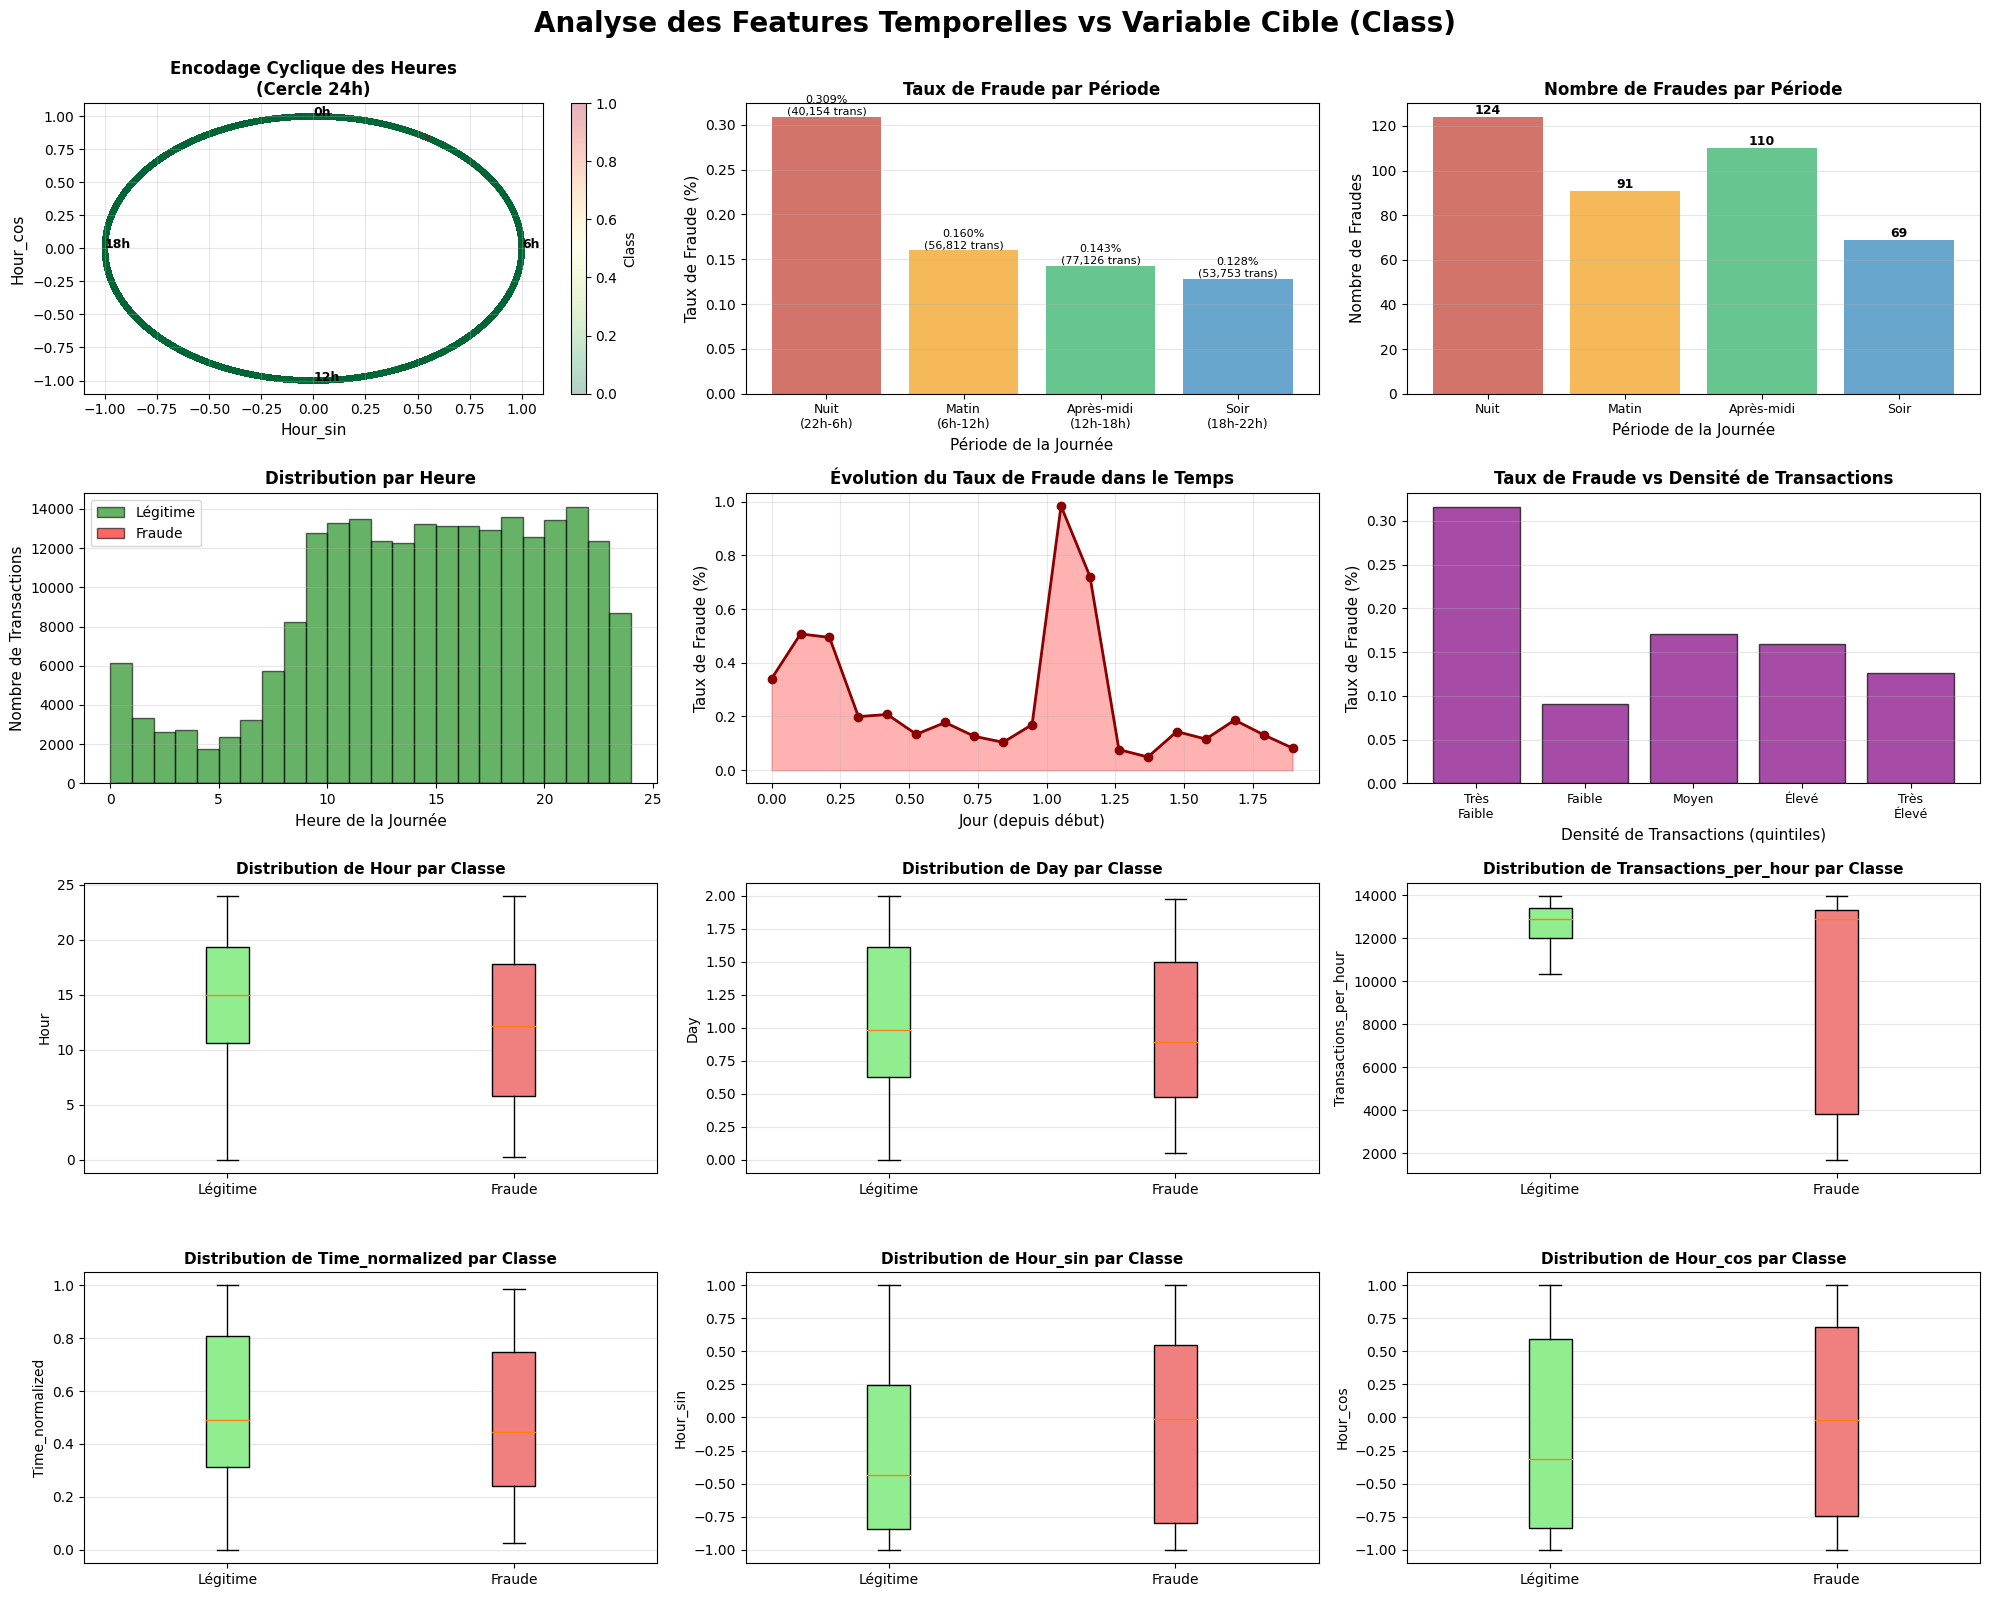


 Analyse d'importance des features temporelles...

IMPORTANCE DES FEATURES TEMPORELLES (Random Forest)
              Feature  Importance
      Time_normalized    0.216386
                 Hour    0.207388
                  Day    0.193021
             Hour_cos    0.191799
             Hour_sin    0.183900
Transactions_per_hour    0.006386
             Is_Night    0.000499
           Is_Morning    0.000404
         Is_Afternoon    0.000160
           Is_Evening    0.000056


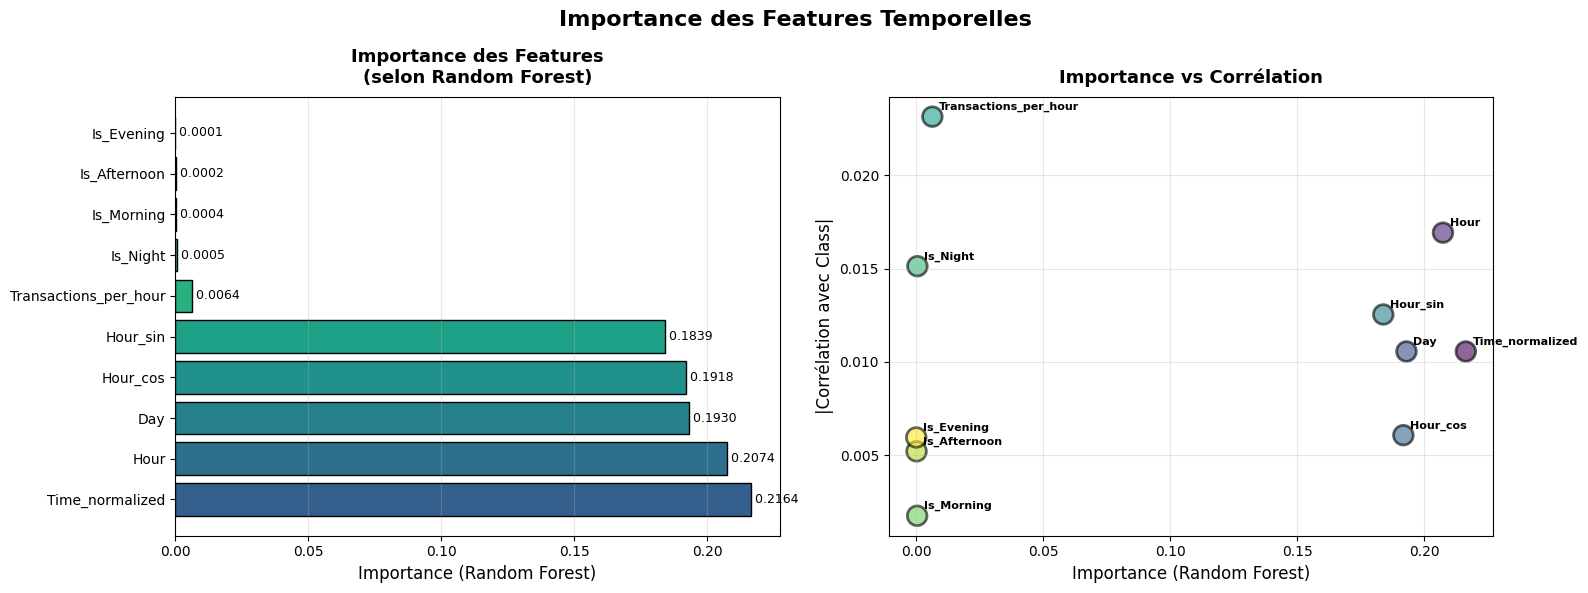

In [29]:
"""
==============================================================================
                        FEATURE ENGINEERING TEMPOREL 
==============================================================================
Objectif : Transformer la variable Time en features temporelles riches
          et analyser leur importance pour la détection de fraude
==============================================================================
"""


print("=" * 80)
print("FEATURE ENGINEERING TEMPOREL")
print("=" * 80)

train_df_enhanced, temporal_features = create_temporal_features(
    train_df, 
    time_col='Time', 
    verbose= True
)

print(f"\n✓ DataFrame amélioré créé !")
print(f"  Shape original : {train_df.shape}")
print(f"  Shape amélioré : {train_df_enhanced.shape}")
print(f"  Nouvelles colonnes : {train_df_enhanced.shape[1] - train_df.shape[1]}")



# ========================================
# PARTIE 2 : VISUALISATIONS PAR RAPPORT À LA VARIABLE CIBLE
# ========================================
print("\n Création des visualisations...")

fig = plt.figure(figsize=(20, 16))
fig.suptitle('Analyse des Features Temporelles vs Variable Cible (Class)', 
             fontsize=20, fontweight='bold', y=0.995)

# ========================================
# VIZ 1 : ENCODAGE CYCLIQUE (SCATTER PLOT)
# ========================================
ax1 = plt.subplot(4, 3, 1)
scatter = ax1.scatter(train_df_enhanced['Hour_sin'], 
                     train_df_enhanced['Hour_cos'],
                     c=train_df_enhanced['Class'], 
                     cmap='RdYlGn_r', 
                     alpha=0.3, 
                     s=10)
ax1.set_xlabel('Hour_sin', fontsize=11)
ax1.set_ylabel('Hour_cos', fontsize=11)
ax1.set_title('Encodage Cyclique des Heures\n(Cercle 24h)', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Class')

# Ajouter des annotations pour les heures clés
for hour, angle in [(0, 0), (6, 90), (12, 180), (18, 270)]:
    sin_val = np.sin(2 * np.pi * hour / 24)
    cos_val = np.cos(2 * np.pi * hour / 24)
    ax1.annotate(f'{hour}h', (sin_val, cos_val), fontsize=9, fontweight='bold')

# ========================================
# VIZ 2 : DISTRIBUTION PAR PÉRIODE - FRAUDES
# ========================================
ax2 = plt.subplot(4, 3, 2)
periods = ['Is_Night', 'Is_Morning', 'Is_Afternoon', 'Is_Evening']
fraud_rates = []
total_transactions = []

for period in periods:
    period_data = train_df_enhanced[train_df_enhanced[period] == 1]
    fraud_rate = period_data['Class'].mean() * 100
    fraud_rates.append(fraud_rate)
    total_transactions.append(len(period_data))

x_pos = np.arange(len(periods))
bars = ax2.bar(x_pos, fraud_rates, color=['#c0392b', '#f39c12', '#27ae60', '#2980b9'], alpha=0.7)
ax2.set_xlabel('Période de la Journée', fontsize=11)
ax2.set_ylabel('Taux de Fraude (%)', fontsize=11)
ax2.set_title('Taux de Fraude par Période', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(['Nuit\n(22h-6h)', 'Matin\n(6h-12h)', 'Après-midi\n(12h-18h)', 'Soir\n(18h-22h)'], fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, (bar, rate, total) in enumerate(zip(bars, fraud_rates, total_transactions)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{rate:.3f}%\n({total:,} trans)',
            ha='center', va='bottom', fontsize=8)

# ========================================
# VIZ 3 : NOMBRE DE FRAUDES PAR PÉRIODE
# ========================================
ax3 = plt.subplot(4, 3, 3)
fraud_counts = []
for period in periods:
    period_frauds = train_df_enhanced[(train_df_enhanced[period] == 1) & 
                                      (train_df_enhanced['Class'] == 1)]
    fraud_counts.append(len(period_frauds))

bars2 = ax3.bar(x_pos, fraud_counts, color=['#c0392b', '#f39c12', '#27ae60', '#2980b9'], alpha=0.7)
ax3.set_xlabel('Période de la Journée', fontsize=11)
ax3.set_ylabel('Nombre de Fraudes', fontsize=11)
ax3.set_title('Nombre de Fraudes par Période', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(['Nuit', 'Matin', 'Après-midi', 'Soir'], fontsize=9)
ax3.grid(axis='y', alpha=0.3)

for bar, count in zip(bars2, fraud_counts):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# ========================================
# VIZ 4 : DISTRIBUTION HEURE (HISTOGRAMME)
# ========================================
ax4 = plt.subplot(4, 3, 4)
ax4.hist(train_df_enhanced[train_df_enhanced['Class'] == 0]['Hour'], 
        bins=24, alpha=0.6, label='Légitime', color='green', edgecolor='black')
ax4.hist(train_df_enhanced[train_df_enhanced['Class'] == 1]['Hour'], 
        bins=24, alpha=0.6, label='Fraude', color='red', edgecolor='black')
ax4.set_xlabel('Heure de la Journée', fontsize=11)
ax4.set_ylabel('Nombre de Transactions', fontsize=11)
ax4.set_title('Distribution par Heure', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# ========================================
# VIZ 5 : ÉVOLUTION PAR JOUR
# ========================================
ax5 = plt.subplot(4, 3, 5)
day_bins = np.linspace(0, train_df_enhanced['Day'].max(), 20)
fraud_by_day = []
for i in range(len(day_bins)-1):
    day_data = train_df_enhanced[(train_df_enhanced['Day'] >= day_bins[i]) & 
                                 (train_df_enhanced['Day'] < day_bins[i+1])]
    if len(day_data) > 0:
        fraud_rate = day_data['Class'].mean() * 100
        fraud_by_day.append(fraud_rate)
    else:
        fraud_by_day.append(0)

ax5.plot(day_bins[:-1], fraud_by_day, marker='o', linewidth=2, markersize=6, color='darkred')
ax5.fill_between(day_bins[:-1], fraud_by_day, alpha=0.3, color='red')
ax5.set_xlabel('Jour (depuis début)', fontsize=11)
ax5.set_ylabel('Taux de Fraude (%)', fontsize=11)
ax5.set_title('Évolution du Taux de Fraude dans le Temps', fontsize=12, fontweight='bold')
ax5.grid(alpha=0.3)

# ========================================
# VIZ 6 : DENSITÉ DE TRANSACTIONS
# ========================================
ax6 = plt.subplot(4, 3, 6)
# Créer des bins de densité
density_bins = pd.qcut(train_df_enhanced['Transactions_per_hour'], q=5, duplicates='drop')
fraud_by_density = train_df_enhanced.groupby(density_bins)['Class'].agg(['mean', 'count'])

ax6.bar(range(len(fraud_by_density)), fraud_by_density['mean'] * 100, 
       color='purple', alpha=0.7, edgecolor='black')
ax6.set_xlabel('Densité de Transactions (quintiles)', fontsize=11)
ax6.set_ylabel('Taux de Fraude (%)', fontsize=11)
ax6.set_title('Taux de Fraude vs Densité de Transactions', fontsize=12, fontweight='bold')
ax6.set_xticks(range(len(fraud_by_density)))
ax6.set_xticklabels(['Très\nFaible', 'Faible', 'Moyen', 'Élevé', 'Très\nÉlevé'], fontsize=9)
ax6.grid(axis='y', alpha=0.3)

# ========================================
# VIZ 7-12 : BOXPLOTS POUR CHAQUE FEATURE
# ========================================
features_to_plot = ['Hour', 'Day', 'Transactions_per_hour', 'Time_normalized', 'Hour_sin', 'Hour_cos']
positions = [7, 8, 9, 10, 11, 12]

for feat, pos in zip(features_to_plot, positions):
    ax = plt.subplot(4, 3, pos)
    data_to_plot = [train_df_enhanced[train_df_enhanced['Class'] == 0][feat],
                    train_df_enhanced[train_df_enhanced['Class'] == 1][feat]]
    bp = ax.boxplot(data_to_plot, labels=['Légitime', 'Fraude'],
                   patch_artist=True, showfliers=False)
    
    # Colorer les boxplots
    colors = ['lightgreen', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_ylabel(feat, fontsize=10)
    ax.set_title(f'Distribution de {feat} par Classe', fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../img/04_temporal_features_analysis.png', dpi=300, bbox_inches='tight')
plt.show()



# ========================================
# PARTIE 3 : ANALYSE D'IMPORTANCE DES FEATURES
# ========================================
print("\n Analyse d'importance des features temporelles...")

# Préparer les données pour Random Forest
X_temp = train_df_enhanced[temporal_features]
y_temp = train_df_enhanced['Class']

# Entraîner un Random Forest rapide pour obtenir l'importance
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf.fit(X_temp, y_temp)

# Obtenir l'importance des features
feature_importance = pd.DataFrame({
    'Feature': temporal_features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "=" * 80)
print("IMPORTANCE DES FEATURES TEMPORELLES (Random Forest)")
print("=" * 80)
print(feature_importance.to_string(index=False))

# Calculer aussi la corrélation avec Class
correlations = train_df_enhanced[temporal_features + ['Class']].corr()['Class'].drop('Class')
feature_importance['Correlation'] = feature_importance['Feature'].map(correlations.abs())
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# ========================================
# VIZ : IMPORTANCE DES FEATURES
# ========================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Importance des Features Temporelles', fontsize=16, fontweight='bold')

# Graphique 1 : Importance Random Forest
ax1 = axes[0]
colors_imp = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance)))
bars1 = ax1.barh(range(len(feature_importance)), feature_importance['Importance'], 
                color=colors_imp, edgecolor='black')
ax1.set_yticks(range(len(feature_importance)))
ax1.set_yticklabels(feature_importance['Feature'])
ax1.set_xlabel('Importance (Random Forest)', fontsize=12)
ax1.set_title('Importance des Features\n(selon Random Forest)', fontsize=13, fontweight='bold', pad=10)
ax1.grid(axis='x', alpha=0.3)

# Ajouter les valeurs
for i, (bar, val) in enumerate(zip(bars1, feature_importance['Importance'])):
    ax1.text(val, bar.get_y() + bar.get_height()/2, 
            f' {val:.4f}', va='center', fontsize=9)

# Graphique 2 : Corrélation vs Importance
ax2 = axes[1]
scatter = ax2.scatter(feature_importance['Importance'], 
                     feature_importance['Correlation'],
                     s=200, c=range(len(feature_importance)), 
                     cmap='viridis', alpha=0.6, edgecolors='black', linewidth=2)
ax2.set_xlabel('Importance (Random Forest)', fontsize=12)
ax2.set_ylabel('|Corrélation avec Class|', fontsize=12)
ax2.set_title('Importance vs Corrélation', fontsize=13, fontweight='bold', pad=10)
ax2.grid(alpha=0.3)

# Annoter les points
for idx, row in feature_importance.iterrows():
    ax2.annotate(row['Feature'], 
                (row['Importance'], row['Correlation']),
                fontsize=8, fontweight='bold',
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.savefig('../img/05_temporal_features_importance.png', dpi=300, bbox_inches='tight')
plt.show()



In [21]:
# Interpretations finales
print("\n" + "=" * 80)
print("POUR LA MODÉLISATION")
print("=" * 80)

print("\n✅ FEATURES À CONSERVER ABSOLUMENT :")
essential = feature_importance[feature_importance['Importance'] >= 0.10]
for feat in essential['Feature']:
    print(f"  - {feat}")

print("\n🟡 FEATURES OPTIONNELLES (importance moyenne) :")
optional = feature_importance[(feature_importance['Importance'] >= 0.05) & 
                             (feature_importance['Importance'] < 0.10)]
for feat in optional['Feature']:
    print(f"  - {feat}")

if len(low_importance) > 0:
    print("\n❌ FEATURES CANDIDATES À L'ÉLIMINATION :")
    for feat in low_importance['Feature']:
        print(f"  - {feat}")



POUR LA MODÉLISATION

✅ FEATURES À CONSERVER ABSOLUMENT :
  - Time_normalized
  - Hour
  - Day
  - Hour_cos
  - Hour_sin

🟡 FEATURES OPTIONNELLES (importance moyenne) :

❌ FEATURES CANDIDATES À L'ÉLIMINATION :
  - Transactions_per_hour
  - Is_Night
  - Is_Morning
  - Is_Afternoon
  - Is_Evening
